# IQA tracking params and variables

> When using parametric layers we have to be able to keep track of the parameters and the variables of the model (which are not going to be trained). We're going to play with this concept using our implementation of the functional layers.

In [ ]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [ ]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

2023-04-30 19:56:55.578859: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-30 19:56:55.631274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 19:56:57.698465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from typing import Any, Callable, Sequence, Union
import numpy as np

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state

import optax

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce

from iqadatasets.datasets import *
from fxlayers.layers import *

## Load the data

> We're going to employ `iqadatasets` to ease the loading of the data.

In [ ]:
dst_train = TID2008("/media/disk/databases/BBDD_video_image/Image_Quality/TID/TID2008/")
dst_val = TID2013("/media/disk/databases/BBDD_video_image/Image_Quality/TID/TID2013/")

In [ ]:
img, img_dist, mos = next(iter(dst_train.dataset))
img.shape, img_dist.shape, mos.shape

2023-04-30 19:57:03.136692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [ ]:
img, img_dist, mos = next(iter(dst_val.dataset))
img.shape, img_dist.shape, mos.shape

2023-04-30 19:57:03.389577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [ ]:
config = {
    "BATCH_SIZE": 32,
    "EPOCHS": 5,
    "LEARNING_RATE": 3e-4,
}
config = ConfigDict(config)
config

BATCH_SIZE: 32
EPOCHS: 5
LEARNING_RATE: 0.0003

In [ ]:
dst_train_rdy = dst_train.dataset.batch(config.BATCH_SIZE, drop_remainder=True)
dst_val_rdy = dst_val.dataset.batch(config.BATCH_SIZE, drop_remainder=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [ ]:
class GDN(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    apply_independently: bool = False
    # feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        denom = nn.Conv(features=inputs.shape[-1], # Same output channels as input
                        kernel_size=self.kernel_size if isinstance(self.kernel_size, Sequence) else [self.kernel_size]*2, 
                        strides=self.strides, 
                        padding=self.padding,
                        # feature_group_count=self.feature_group_count,
                        feature_group_count=inputs.shape[-1] if self.apply_independently else 1,
                        kernel_init=self.kernel_init, 
                        bias_init=self.bias_init)(inputs**self.alpha)
        denom = nn.relu(denom)
        return inputs / (denom**self.epsilon + self.eps)

In [ ]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        outputs = nn.Conv(features=3, kernel_size=(5,5), strides=1, padding="SAME")(inputs)
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=True)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = nn.Conv(features=6, kernel_size=(5,5), strides=1, padding="SAME")(outputs)
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GaborLayer(features=128, kernel_size=21, strides=1, padding="SAME", fs=21)(outputs, **kwargs)
        # outputs = nn.Conv(features=128, kernel_size=(5,5), strides=1, padding="SAME")(outputs)
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        return outputs

## Define the metrics with `clu`

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [ ]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [ ]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [ ]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [ ]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [ ]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Train the model!

In [ ]:
state = create_train_state(PerceptNet(), random.PRNGKey(0), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))

In [ ]:
metrics_history = {
    "train_loss": [],
    "val_loss": [],
}

In [ ]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state = train_step(state, batch)
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]}')
    # break

2023-04-30 19:57:15.232964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-30 19:58:01.771566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 0 -> [Train] Loss: -0.3694571852684021 [Val] Loss: -0.5647238492965698
Epoch 1 -> [Train] Loss: -0.4500204622745514 [Val] Loss: -0.6486803889274597
Epoch 2 -> [Train] Loss: -0.5101209878921509 [Val] Loss: -0.5459914207458496
Epoch 3 -> [Train] Loss: -0.4495947062969208 [Val] Loss: -0.6351958513259888
Epoch 4 -> [Train] Loss: -0.32780590653419495 [Val] Loss: -0.38518646359443665
CPU times: user 13min 26s, sys: 18min 59s, total: 32min 26s
Wall time: 4min 21s


In [ ]:
import matplotlib.pyplot as plt
from einops import rearrange

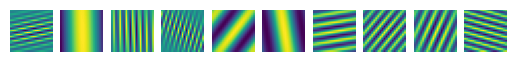

In [ ]:
filters = rearrange(state.state["precalc_filter"]["GaborLayer_0"]["kernel"], "kx ky cin cout -> (cin cout) kx ky")[:10]
fig, axes = plt.subplots(1,len(filters))
for k, ax in zip(filters, axes.ravel()):
    ax.imshow(k)
    ax.axis("off")
plt.show()